# Evaluating the neuron quality
### Take the data from the neuronal segmentation pipeline and evaluate which neurons are good, save results

In [160]:
# Load the libraries
import caiman as cm
from caiman.source_extraction import cnmf

import matplotlib.pyplot as plt
from matplotlib.widgets import Button, TextBox
from matplotlib.patches import Polygon
from matplotlib.path import Path
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import json
from scipy.sparse import csc_matrix
from scipy.stats import sem
from scipy import stats
import statistics

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn import linear_model as lm

import cv2
from itertools import compress

from IPython import get_ipython
import IPython

from ipyfilechooser import FileChooser

from scipy.ndimage import binary_erosion
from scipy.ndimage import grey_erosion

try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the data

In [ ]:
# Set the starting folder
start_path = 'D:\CaIm'
%cd $start_path

# Create and display a FileChooser widget
fc = FileChooser(start_path)
fc.use_dir_icons = True
display(fc)

In [289]:
# Load the data
#path = 'D:/CaIm/os80/b2/'
path = fc.selected_path 

traces_path = path + 'traces.json'
component_locations_path = path + 'component_locations.json'
filter_img_path = path + 'filter_img.json'
accepted_path = path + 'accepted.json'
with open(traces_path, 'r') as json_file:
    traces_list = json.load(json_file)
with open(component_locations_path, 'r') as json_file:
    component_locations_list = json.load(json_file)
with open(filter_img_path, 'r') as json_file:
    filter_img = json.load(json_file)
with open(accepted_path, 'r') as json_file:
    accepted_list = json.load(json_file)

# Convert to convinient formats
component_locations = np.array(component_locations_list)
component_locations_sparse = csc_matrix(component_locations)
traces = np.array(traces_list)
filter_img = np.array(filter_img)

# Display the number of components total and the rejected ones
print(f"Total number of components: {traces.shape[0]}, accepted: {len(accepted_list)}")
      
# Select only accepted:
#component_locations = component_locations[:,accepted_list]
# traces = traces[accepted_list,:]

Total number of components: 466, accepted: 442


## Select a polygon where neurons could be

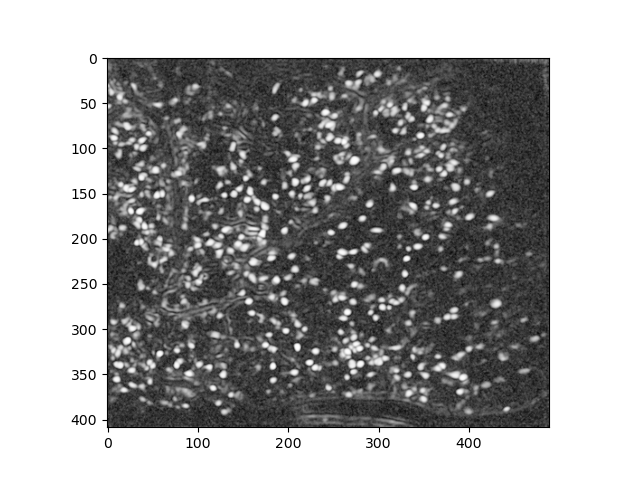

In [5]:
%matplotlib widget

fig, ax = plt.subplots()
ax.imshow(filter_img, cmap='gray')
polygon_points = []
polygon_complete = False

def on_click(event):
    if event.inaxes is not None:
        polygon_points.append((event.xdata, event.ydata))
        ax.plot(event.xdata, event.ydata, 'ro')  # Mark the vertices

def on_key_p(event):
    global polygon_points
    if event.key == 'p':  # on pressing 'p'
        poly = Polygon(polygon_points, closed=True, edgecolor='r', fill=False)
        ax.add_patch(poly)
        fig.canvas.mpl_disconnect(cid) 
        plt.draw()
        print("Polygon complete")


cid = fig.canvas.mpl_connect('button_press_event', on_click)
fig.canvas.mpl_connect('key_press_event', on_key_p)
plt.show()

## Discard components outside of the polygon

In [6]:
# Original dimentions
d1 = filter_img.shape[1]
d2 = filter_img.shape[0]

def calculate_centroid(component_locations, component_num, d1, d2):
    """Calculate the centroid of a component."""
    component = component_locations[:, component_num].reshape(d1, d2)
    ys, xs = np.nonzero(component)
    if len(xs) == 0 or len(ys) == 0:
        return None  # or some default value like (0, 0)
    return np.mean(xs), np.mean(ys)

centroids = [calculate_centroid(component_locations, i, d1, d2) for i in np.arange(component_locations.shape[1])]

# Filter out None values if there are any
centroids = [centroid for centroid in centroids if centroid is not None]


def is_inside_polygon(points, polygon):
    path = Path(polygon)
    return np.array([path.contains_point(point) for point in points])

is_inside = is_inside_polygon(centroids, polygon_points)

# Filter arrays
print(f"Total number of components before: {traces.shape[0]}")
#component_locations = component_locations[:, is_inside]
#traces = traces[is_inside, :]
print(f"Now: {traces.shape[0]}")

Total number of components now: 406


## Make components sharper

In [290]:
component_locs_sharp =[]
for n in np.arange(component_locations.shape[1]):
    comp = component_locations[:,n]
    comp_no0 = comp[comp>0]
    
    
    mean_comp = np.mean(comp_no0)
    sd_comp = statistics.stdev(comp_no0)
    cutoff = mean_comp
    sharper = np.where(comp < cutoff, 0, comp)
    component_locs_sharp.append(sharper)

## Make image of all components outlines on top of the filtered image and just look at it

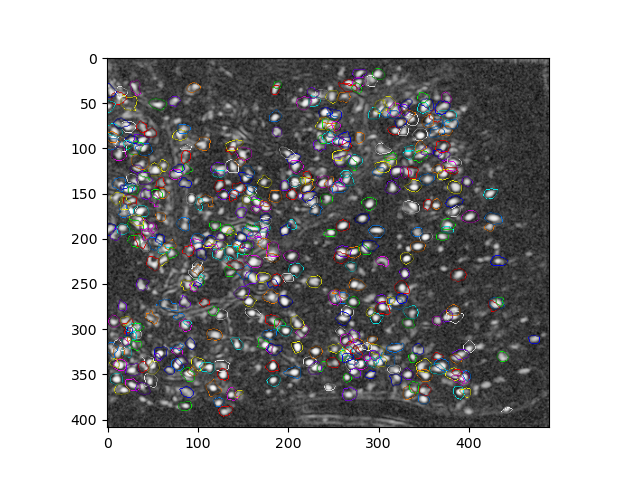

In [291]:
fig, ax = plt.subplots()
ax.imshow(filter_img, cmap='gray')

colors = [ [ 1,  0,  0, 1],
           [ 0,  1,  0, 1],
           [ 0,  0,  1, 1],
           [ 0,  1,  1, 1],
           [ 1,  0,  1, 1],
           [ 1,  1,  0, 1],
           [ 1,  1,  1, 1],
           [.5,  0,  1, 1],
           [ 1, .5,  0, 1],
           [ 0, .5,  1, 1],
         ]

def plot_boundaries(ax, component, color):

    # Convert to boolean 
    component_bool = component.astype(bool)
    # Find boundaries (edges)
    eroded = binary_erosion(component_bool)
    boundaries = component_bool & ~eroded
    # Create a color mask: yellow for True, transparent for False
    color_mask = np.zeros((boundaries.shape[0], boundaries.shape[1], 4))  # Initialize a RGBA color mask
    color_mask[boundaries] = color  # Yellow (R=1, G=1, B=0, A=1) for True values
    # Overlay boundaries
    ax.imshow(color_mask, cmap='gray', alpha=1)
    

for n in np.arange(len(component_locs_sharp)):
    color = colors[:][n%len(colors)]
    component = np.array(component_locs_sharp[n])
    component = component.reshape(d2, d1, order='F')
    plot_boundaries(ax, component, color)

plt.show()

In [ ]:
plt.savefig('D:/CaIm/os80/b2/sharp_outlines1.png')  # Save as PNG file

In [29]:
neuron

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Evaluate roundness

(array([ 2.,  1.,  2.,  5.,  5., 16., 28., 62., 75., 75., 75., 33., 17.,
         6.,  1.,  1.,  1.,  0.,  0.,  1.]),
 array([0.7464528 , 0.80579455, 0.8651363 , 0.92447805, 0.9838198 ,
        1.04316155, 1.1025033 , 1.16184505, 1.22118679, 1.28052854,
        1.33987029, 1.39921204, 1.45855379, 1.51789554, 1.57723729,
        1.63657904, 1.69592079, 1.75526254, 1.81460429, 1.87394604,
        1.93328779]),
 <BarContainer object of 20 artists>)

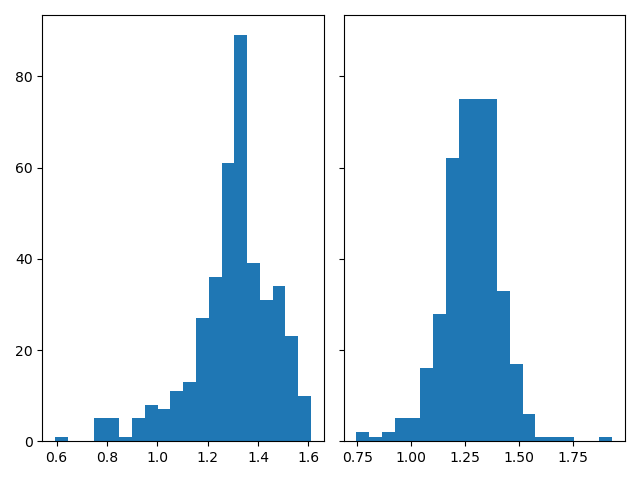

In [52]:
import cv2

def calculate_circularity(neuron):
    # Find area (non-zero pixels)
    area = np.count_nonzero(neuron)
    
    # Find perimeter (using edge detection, e.g., Canny)
  #  edges = cv2.Canny(neuron, threshold1=100, threshold2=200)
    
    neuron_bool = neuron.astype(bool)
    # Find boundaries (edges)
    eroded = binary_erosion(neuron_bool)
    boundaries = neuron_bool & ~eroded
    perimeter = np.count_nonzero(boundaries)
    
    if perimeter == 0:
        return 0  # To avoid division by zero
    
    # Calculate circularity
    circularity = 4 * np.pi * area / (perimeter ** 2)
    return circularity

circs = []
circs_sharp = []
for n in np.arange(traces.shape[0]):
    neuron = component_locations[:,n].reshape(d2, d1, order='F')
    neuron_sharp = component_locs_sharp[n].reshape(d2, d1, order='F')
    circ = calculate_circularity(neuron)
    circ_sharp = calculate_circularity(neuron_sharp)
    circs.append(circ)
    circs_sharp.append(circ_sharp)
  #  print(f"Neuron#{n+1} circularity reg: {round(circ,3)}, sharp:{round(circ_sharp,3)}")
    

n_bins = 20

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(circs, bins=n_bins)
axs[1].hist(circs_sharp, bins=n_bins)

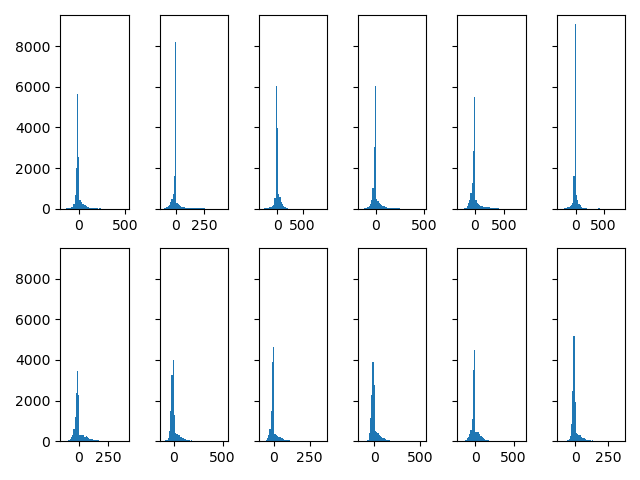

In [114]:
diffs_good = []
diffs_mid = []
diffs_bad = []
neus = [[4,6,9, 32,58,65],[2,3,14, 15,18,26]]
for neu in neus[0]:
    diffs= []
    for n in np.arange(traces.shape[1]-1):
        diff = traces[neu][n+1] - traces[neu][n]
        diffs.append(diff)
    diffs_good.append(diffs)

for neu in neus[1]:
    diffs= []
    for n in np.arange(traces.shape[1]-1):
        diff = traces[neu][n+1] - traces[neu][n]
        diffs.append(diff)
    diffs_bad.append(diffs)

n_bins =50

fig, axs = plt.subplots(2,len (neus[0]) , sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.

for n in np.arange( len (neus[0]) ):
    axs[0,n].hist(diffs_good[n], bins=n_bins)
    axs[1,n].hist(diffs_bad[n], bins=n_bins)

In [70]:
neus = [[6,9,58],[0,5,62],[2,3,15]]
neus[0]

[6, 9, 58]

In [ ]:
### Calculate standard deviation and SNR

In [185]:
snrs = []
st_devs = []
kurts = []
means = []
medians = []
skews = []
for n in np.arange(traces.shape[0]):
    st_dev = np.std(traces[n])
    mean_tr = np.mean(traces[n])
    snr = mean_tr/st_dev
    medians.append(np.median(traces[n]))
    means.append(mean_tr)
    kurts.append(stats.kurtosis(traces[n]))
    snrs.append(snr)
    st_devs.append(st_dev)
    skews.append(stats.skew(traces[n]))

## plot a neuron location on the overlay of the max image and a trace of this neuron

0 63 0 94


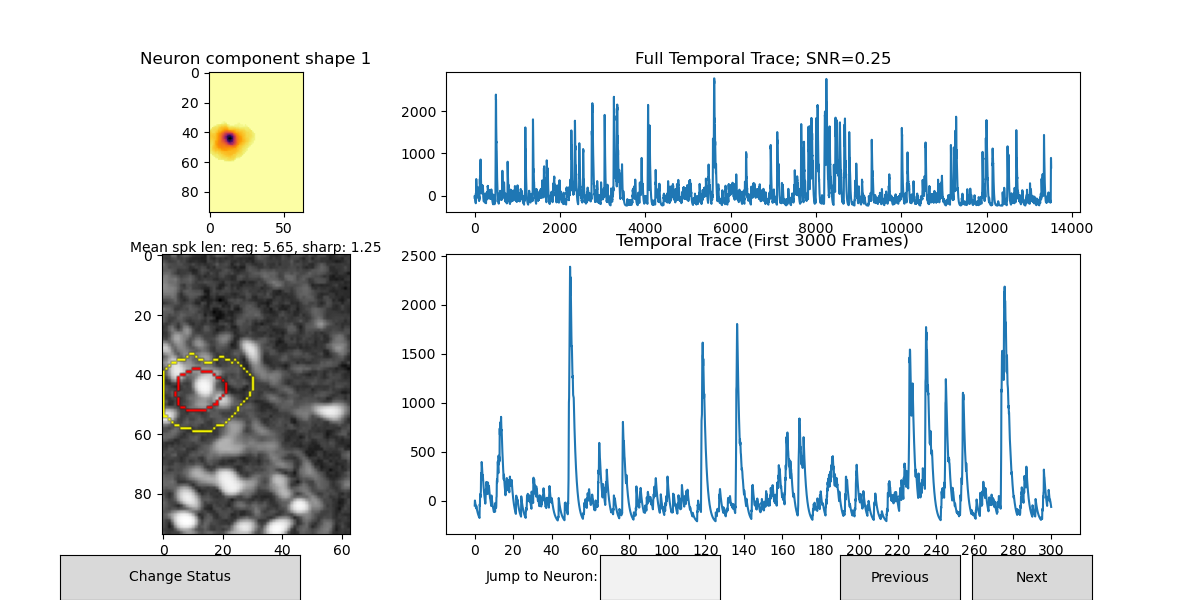

In [288]:
%matplotlib widget
#component_locations = component_locations[:, is_inside]
#traces = traces[is_inside, :]
# Initial component number
component_num = 0

staatus_array = np.zeros((component_locations.shape[1]), dtype=int)

# Plot a certain neuron
def update_plot(component_num):

    spatial_comp = component_locations[:, component_num].reshape(d2, d1, order='F')
    spatial_comp_sharp = component_locs_sharp[:][component_num].reshape(d2, d1, order='F')
    temporal_comp = traces[component_num, :]
   # centroid_x, centroid_y = calculate_centroid(component_locations, component_num, d1, d2)

    # Define crop boundaries
    centroid_y, centroid_x = np.unravel_index(np.argmax(spatial_comp, axis=None),spatial_comp.shape)
    crop_size = 50
    x_min, x_max = round(max(0, centroid_x - crop_size)), round(min(d2, centroid_x + crop_size))
    y_min, y_max = round(max(0, centroid_y - crop_size)), round(min(d1, centroid_y + crop_size))
    print(x_min, x_max, y_min, y_max)
    crop_bounds = (y_min, y_max, x_min, x_max)
    # Crop the image and spatial_comp
    crop_image = filter_img[y_min:y_max, x_min:x_max]
    crop_spatial_comp = spatial_comp[y_min:y_max, x_min:x_max]
    crop_spatial_comp_sharp = spatial_comp_sharp[y_min:y_max, x_min:x_max]

    axs[0].clear()
    axs[0].imshow(crop_spatial_comp, cmap='inferno_r')
    axs[0].set_title(f'Neuron component shape {component_num + 1}')
    axs[0].set_xlabel('Mean spk len: reg: ' + str(round(mean_spikes[component_num],2))
                      + ', sharp: ' + str(round(circs_sharp[component_num],2)))
    
    axs[1].clear()
    axs[1].imshow(crop_image, cmap='grey')
   # axs[1].imshow(crop_spatial_comp, cmap='inferno_r', alpha=0.3)
    plot_boundaries(axs[1], crop_spatial_comp, [1,1,0,1], crop_bounds)
    plot_boundaries(axs[1], crop_spatial_comp_sharp, [1,0,0,1], crop_bounds)
 #   axs[1].set_title(f'Neuron location {component_num + 1}')
    
    # Plot temporal components
    temporal_comp = traces[component_num, :]
    axs[2].clear()
    axs[2].plot(temporal_comp)
    axs[2].set_title(f'Full Temporal Trace; SNR={round(snrs[component_num],2)}')


    axs[3].clear()

    axs[3].plot(temporal_comp[:3000])
    axs[3].set_title('Temporal Trace (First 3000 Frames)')
    axs[3].set_xticks(np.arange(0,3001,200), np.arange(0,301,20))
    
    
    plt.draw()

def next_neuron(event):
    global component_num
     # Check if the component is inside the previously selected polygon, if not - skip to the next one
    component_num = (component_num + 1) % component_locations.shape[1]
    while not is_inside[component_num]:
        component_num = (component_num + 1) % component_locations.shape[1]   
    update_plot(component_num)

def prev_neuron(event):
    global component_num
    # Check if the component is inside the previously selected polygon, if not - skip to the previous one
    component_num = (component_num - 1) % component_locations.shape[1]
    while not is_inside[component_num]:
        component_num = (component_num - 1) % component_locations.shape[1] 
    update_plot(component_num)

def jump_to_neuron(text):
    global component_num
    component_num = int(text) - 1
    update_plot(component_num)

def change_status(event):
    staatus_array[component_num] = 1 # if status_array[component_num] == 0 else 0
   # print(f"Status of Neuron {component_num + 1}: {status_array[component_num]}")

def on_key_g(event):
    global component_num, status_array
    if event.key == 'g':  # Change 'n' to your desired key
        staatus_array[component_num] = 1 # if status_array[component_num] == 0 else 0
        print(f"Status of Neuron {component_num + 1}: {staatus_array[component_num]}")
        update_plot(component_num)  




def plot_boundaries(ax, component, color,  crop_bounds=None):
    if crop_bounds==None:
        crop_comp = component
    else:
        y_min, y_max, x_min, x_max = crop_bounds
        crop_comp = component[y_min:y_max, x_min:x_max]
    # Convert to boolean 
    component_bool = component.astype(bool)
    # Find boundaries (edges)
    eroded = binary_erosion(component_bool)
    boundaries = component_bool & ~eroded
    # Create a color mask: yellow for True, transparent for False
    color_mask = np.zeros((boundaries.shape[0], boundaries.shape[1], 4))  # Initialize a RGBA color mask
    color_mask[boundaries] = color  # Yellow (R=1, G=1, B=0, A=1) for True values
    # Overlay boundaries
    ax.imshow(color_mask, cmap='gray', alpha=1)



# Create plot with GridSpec
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 2], width_ratios=[1, 3])  # Adjust ratios as needed

ax0 = fig.add_subplot(gs[0, 0])  # 0st subplot for the component map
ax1 = fig.add_subplot(gs[1, 0])  # First subplot for the neuron image
ax2 = fig.add_subplot(gs[0, 1])  # Second subplot for the entire trace
ax3 = fig.add_subplot(gs[1, 1])  # Third subplot for the zoomed trace

axs = [ax0, ax1, ax2, ax3]

update_plot(component_num)

# Adjust button positions
axprev = plt.axes([0.7, 0.0, 0.1, 0.075])
axnext = plt.axes([0.81, 0.0, 0.1, 0.075])
axtextbox = plt.axes([0.5, 0.0, 0.1, 0.075])
axstatus = plt.axes([0.05, 0.0, 0.2, 0.075])

# 
btn_next = Button(axnext, 'Next')
btn_next.on_clicked(next_neuron)

btn_prev = Button(axprev, 'Previous')
btn_prev.on_clicked(prev_neuron)

text_box = TextBox(axtextbox, 'Jump to Neuron:')
text_box.on_submit(jump_to_neuron)

btn_status = Button(axstatus, 'Change Status')
btn_status.on_clicked(change_status)
fig.canvas.mpl_connect('key_press_event', on_key_g)
plt.show()

In [87]:
# Convert status_array to a DataFrame
status_df = pd.DataFrame(status_array, columns=['Status'])
status_df.to_csv('good_neurons.csv', index=False)

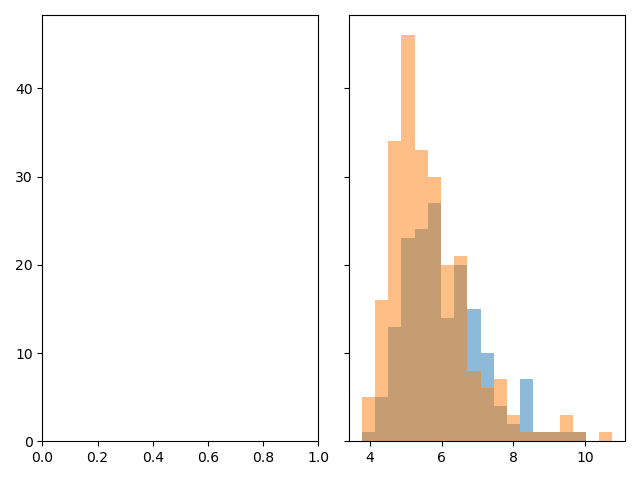

In [283]:
status_array_bool = status_array.astype(bool)
baddies = [not x for x in status_array_bool]
good_circs = list(compress(circs, status_array_bool))
bad_circs = list(compress(circs, baddies))
good_circs_sharp = list(compress(circs_sharp, status_array_bool))
bad_circs_sharp = list(compress(circs_sharp, baddies))
skews_good = list(compress(skews, status_array_bool))
skews_bad = list(compress(skews, baddies))

rise_fall_ratios

rfrs_good = list(compress(rise_fall_ratios, status_array_bool))
rfrs_bad = list(compress(rise_fall_ratios, baddies))

mean_spikes
mean_spikes_good = list(compress(mean_spikes, status_array_bool))
mean_spikes_bad = list(compress(mean_spikes, baddies))

n_bins = 20


fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.

#bins = np.linspace(min(skews), max(skews), n_bins)
#axs[0].hist(bad_circs, alpha=0.5, bins=bins)

bins = np.linspace(min(mean_spikes), max(mean_spikes), n_bins)
axs[1].hist(mean_spikes_good, alpha=0.5, bins=bins)
axs[1].hist(mean_spikes_bad, alpha=0.5, bins=bins)
plt.show()

In [150]:
skews_good

[3.411417636148033,
 3.1625443478998614,
 3.0786989035784997,
 2.2824811739867714,
 4.615196962732037,
 4.64853587732432,
 1.919273252216658,
 3.2372267844774374,
 3.1435153716014095,
 2.9139890171457874,
 2.2823416213010774,
 1.758493189310668,
 2.2294848219180046,
 2.512629194066496,
 2.91336780511006,
 2.1102003216433634,
 2.3799015585039567,
 2.6803096634415517,
 3.04429765089135,
 2.0240369709797417,
 2.362053632182488,
 3.0368337630112077,
 2.515749938743846,
 4.2663096926738,
 1.6483279039330585,
 2.660942958215924,
 4.571275607631896,
 2.6430608571245804,
 3.4111674357461093,
 1.4978408391877522,
 4.366681320896639,
 4.381474009821652,
 2.680847787793491,
 2.7900544978466253,
 2.6676431335771698,
 3.7442965659929435,
 1.2530193656735047,
 2.290972837332381,
 3.0832865063513077,
 1.8458666385433313,
 3.9033867858007514,
 4.155133733870518,
 2.1904361156754706,
 3.8318335437769258,
 4.513675973486757,
 2.259288278160348,
 2.824173203295459,
 2.8978762972665493,
 4.245346086427611

In [133]:
stats.kurtosis(traces[0])

7.698603713432355

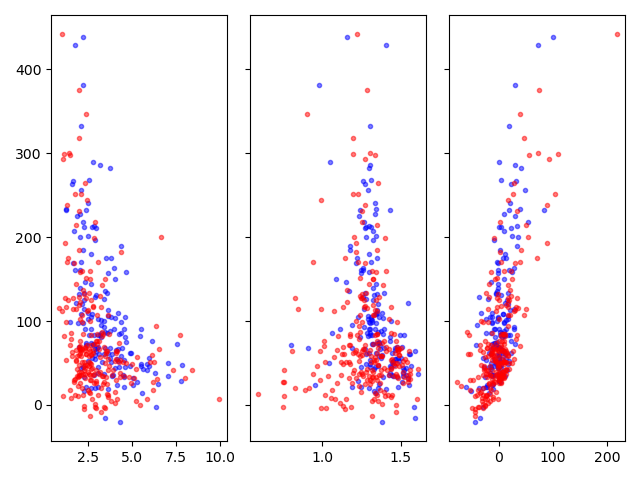

In [187]:
snrs_good = list(compress(snrs, status_array_bool))
snrs_bad = list(compress(snrs, baddies))
st_devs_good = list(compress(st_devs, status_array_bool))
st_devs_bad = list(compress(st_devs, baddies))

kurts_good = list(compress(kurts, status_array_bool))
kurts_bad = list(compress(kurts, baddies))

means_good = list(compress(means, status_array_bool))
means_bad = list(compress(means, baddies))

medians_good = list(compress(medians, status_array_bool))
medians_bad = list(compress(medians, baddies))

fig, axs = plt.subplots(1,3, tight_layout=True)
mark_size=3
axs[0].plot(skews_good, means_good, 'bo', ms=mark_size, alpha=0.5)
axs[0].plot(skews_bad, means_bad, 'ro', ms=mark_size, alpha=0.5)

axs[1].plot(good_circs, means_good, 'bo', ms=mark_size, alpha=0.5)
axs[1].plot(bad_circs, means_bad, 'ro', ms=mark_size, alpha=0.5)

axs[2].plot(medians_good, means_good, 'bo', ms=mark_size, alpha=0.5)
axs[2].plot(medians_bad, means_bad, 'ro', ms=mark_size, alpha=0.5)
plt.show()

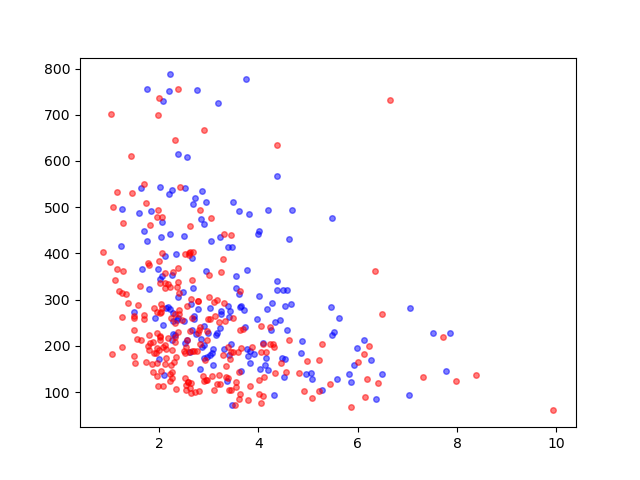

In [159]:
fig, axs = plt.subplots()
mark_size=4

plt.plot(skews_good, st_devs_good, 'bo', ms=mark_size, alpha=0.5)
plt.plot(skews_bad, st_devs_bad, 'ro', ms=mark_size, alpha=0.5)
plt.show()

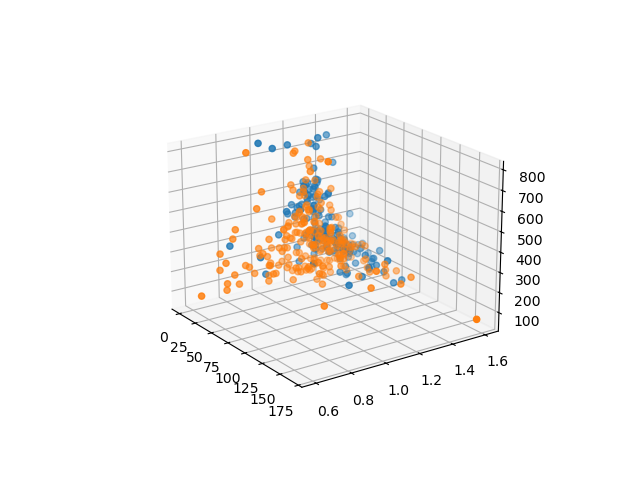

In [136]:

ax = plt.figure().add_subplot(projection='3d')

# Plot a sin curve using the x and y axes.
x = np.linspace(0, 1, 100)
y = np.sin(x * 2 * np.pi) / 2 + 0.5
ax.scatter(kurts_good, good_circs, st_devs_good, zdir='z')
ax.scatter(kurts_bad, bad_circs, st_devs_bad, zdir='z')
# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
ax.view_init(elev=20., azim=-35, roll=0)

plt.show()

In [ ]:
model = lm.LogisticRegression(random_state=0)

In [295]:
# Combine into a feature matrix and target vector y
features = np.column_stack((circs, circs_sharp, st_devs, kurts, skews, medians, means))
good = np.array(status_array_bool)

X_train, X_test, y_train, y_test = train_test_split(features, good, test_size=0.2, random_state=0)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.6585365853658537
              precision    recall  f1-score   support

       False       0.67      0.70      0.68        43
        True       0.65      0.62      0.63        39

    accuracy                           0.66        82
   macro avg       0.66      0.66      0.66        82
weighted avg       0.66      0.66      0.66        82



### Accuracies:
log_regr_all: 65


In [221]:
neus = [[4,6,9, 32,58,65],[2,3,14, 15,18,26]]
neu_good = traces[6]
neu_bad = traces[2]
rising = 1
falling = 1
rises = []
falls = []
for neu in neus[0]:
    for t in np.arange(len(neu_good)-1):
        neur = traces[neu]
        if neur[t] < neur[t+1]:
            rising +=1
        else:
            falling+=1
    print(rising,falling, rising/falling)

        

2507 11005 0.22780554293502953
4253 22769 0.18678905529447934
7019 33513 0.20944111240414168
9571 44471 0.2152189067032448
12051 55501 0.21713122286084935
14193 66869 0.2122508187650481


In [282]:
neus = [[4,6,9, 32,58,65],[2,3,14, 15,18,26]]
neu_good = traces[6]
neu_bad = traces[2]
rising = 1
falling = 1
rises = []
falls = []
rise_fall_ratios = []
mean_spikes = []
for neu in np.arange(len(traces)):
    rises = []
    falls = []
    neur = traces[neu]
    if neur[0]>neur[1]:
        rising = 0
        falling = 1
    else:
        rising=1
        falling=0
    spikes = []
    spk_thr = np.mean(neur)+np.std(neur)
    spike_max = 0
    for t in np.arange(1, len(neu_good)-2):
        if neur[t+1] < neur[t+2]:
            rising += 1
            if falling>0:
                if len(rises)>0 & (spike_max>spk_thr):
                    spikes.append(round(falling/rises[-1],2))
                falls.append(falling)
                falling=0
        else:
            falling += 1
            if rising>0:
                spike_max = neur[t+1]
                rises.append(rising)
                rising = 0
#    print(np.mean(spikes))
    mean_spikes.append(np.mean(spikes))




hop
hop
hop
hop
ho
ho
ho
ho


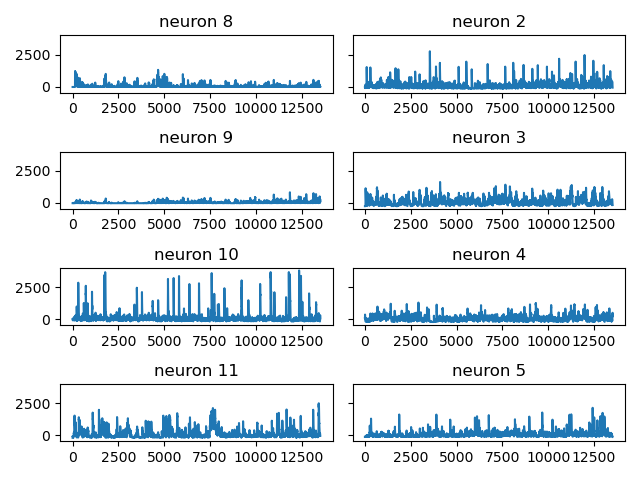

In [247]:
fig, axs = plt.subplots(4,2, sharey=True, tight_layout=True)
pl=0
while pl <4:
    for n in np.arange(len(rise_fall_ratios)):
        if pl > 3:
            break
        if rise_fall_ratios[n]<0.217:
            print("hop")
            axs[pl,0].plot(traces[n])
            axs[pl,0].set_title(f"neuron {n+1}")
            pl+=1

pl=0
while pl <4:
    for n in np.arange(len(rise_fall_ratios)):
        if pl > 3:
            break
        if rise_fall_ratios[n]>0.24:
            print("ho")
            axs[pl,1].plot(traces[n])
            axs[pl,1].set_title(f"neuron {n+1}")
            pl+=1

plt.show()
